# Seasonal SIRS Modular β(t) on the Month Circle (Ontario, 2014–2019)

We study seasonal influenza dynamics in Ontario using an SIRS model with a smoothly varying transmission rate β(t). 
Seasonal effects enter through four base values (Spring, Summer, Fall, Winter) blended on the month circle to ensure continuity across December to January. 
We estimate parameters by combining a coarse grid search with a brief stochastic refinement, and we scale model incidence to reported counts via a single non-negative κ obtained in closed form.

## Notebook roadmap

We organize the analysis as follows:

1. **Environment and constants** : imports, plotting style, season labels.
2. **Season utilities** : month-circle smoothing and an explicit meteorological season map.
3. **Data ingestion** : a robust CSV reader that detects Year/Month/Cases with minimal assumptions.
4. **Simulator** : daily SIRS updates with midpoint incidence and probability safeguards.
5. **Scaling and metrics** : single-κ fit and fit quality metrics.
6. **Objective with prior** : winter-upweighted loss and a soft monotonicity prior (Winter ≥ Fall ≥ Spring ≥ Summer).
7. **Search and refinement** : coarse grid followed by annealed random steps.
8. **Reporting and visualization** : summary dictionary and an Observed vs Fitted plot.

Throughout, we keep S+I+R=1 numerically and report both global and winter-specific errors.

## Environment and data assumptions

We work with standard scientific Python libraries (NumPy, pandas, Matplotlib). 
The analysis expects a CSV with monthly influenza counts and reasonable column names (any of _Year_, _Month_, and a case/count-like column); 
the loader also handles a single _Date_ column by parsing month and year. 
Unless stated otherwise, we restrict fitting to 2014–2019 to match the period of interest.

In [10]:
# ================================================================
# HERE WE GO:
# Seasonal SIRS Modular β(t) on the Month Circle (Ontario 2014–2019)
# - Robust CSV load (auto Year/Month/Cases detection)
# - Meteorological seasons with circular (modular) smoothing of β(t)
# - Stable daily Euler + midpoint incidence + [0,1] clamps + renormalization
# - Single κ (analytic, non-negative) for interpretability
# - Grid + stochastic refinement for {β_s, ω, I0}, with monotone prior
# - Winter-upweighted objective (optional) + rich metrics & plots
# ================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from pathlib import Path
import re, json, math

# ---------- Matplotlib style ----------
plt.style.use('ggplot')
plt.rcParams.update({
    'font.size': 12,
    'figure.figsize': (13, 5.8),
    'axes.titlesize': 14,
    'axes.labelsize': 12
})

# ---------- Season constants ----------
SPRING, SUMMER, FALL, WINTER = 0, 1, 2, 3
SEASON_NAMES  = {SPRING:'Spring', SUMMER:'Summer', FALL:'Fall', WINTER:'Winter'}
SEASON_COLORS = {SPRING:'lightgreen', SUMMER:'khaki', FALL:'orange', WINTER:'lightblue'}

# Month centers (1..12) for modular smoothing (meteorological):
# Feb≈2, May≈5, Aug≈8, Nov≈11 would also work. Here we align to Apr/Jul/Oct/Jan.
SEASON_CENTERS = {
    SPRING: 4.0,   # centered in April (Mar–May)
    SUMMER: 7.0,   # July (Jun–Aug)
    FALL:  10.0,   # Oct (Sep–Nov)
    WINTER: 1.0    # Jan (Dec–Feb) — note wrap-around
}

## Season utilities

We encode meteorological seasons explicitly (Winter: Dec–Feb, Spring: Mar–May, Summer: Jun–Aug, Fall: Sep–Nov) 
and define four month centers on the 1..12 circle. 
Gaussian weights around these centers blend the four seasonal β values to produce a smooth β(t).

In [2]:
# ---------- Seasons (explicit, meteorological) ----------
def season_of(date: pd.Timestamp) -> int:
    y = date.year
    if (date >= pd.Timestamp(y,12,1)) or (date < pd.Timestamp(y,3,1)):
        return WINTER
    if pd.Timestamp(y,3,1)  <= date < pd.Timestamp(y,6,1):
        return SPRING
    if pd.Timestamp(y,6,1)  <= date < pd.Timestamp(y,9,1):
        return SUMMER
    return FALL  # Sep–Nov

# ---------- Modular smoothing utilities ----------
def circular_distance(m: float, c: float, period: float = 12.0) -> float:
    """Shortest distance on a circle of length 'period'."""
    d = abs(m - c) % period
    return min(d, period - d)

def modular_beta_for_date(date: pd.Timestamp, betas: dict, sigma_months: float = 0.8) -> float:
    """
    Smooth β(t) by blending seasonal β_s with Gaussian weights on the month circle.
    Ensures continuity across Dec→Jan using circular (mod) distance.
    """
    m = float(date.month)  # 1..12
    # Unnormalized weights
    w = {}
    for s in [SPRING, SUMMER, FALL, WINTER]:
        d = circular_distance(m, SEASON_CENTERS[s], 12.0)
        w[s] = math.exp(-(d*d) / (2.0*sigma_months*sigma_months))
    Z = sum(w.values())
    for s in w: w[s] /= (Z + 1e-12)
    return sum(w[s] * betas[s] for s in w)

## Data ingestion

The loader searches for a header row if it is not on the first line, tolerates different encodings, 
accepts month names or numbers, and chooses a sensible case-like column when several candidates exist. 
After cleaning, we aggregate by month and attach a season label to each monthly record.

In [3]:
# ---------- Ultra-robust CSV loader ----------
_MONTH_MAP = {
    'jan':1,'january':1,'feb':2,'february':2,'mar':3,'march':3,'apr':4,'april':4,
    'may':5,'jun':6,'june':6,'jul':7,'july':7,'aug':8,'august':8,'sep':9,'sept':9,
    'september':9,'oct':10,'october':10,'nov':11,'november':11,'dec':12,'december':12
}

def _canonical_name_map(cols):
    return {c: re.sub(r'\s+',' ',str(c)).strip().lower() for c in cols}

def _read_with_header_detection(csv_path):
    lines = []
    for enc in ['utf-8-sig','utf-8','latin-1']:
        try:
            with open(csv_path, 'r', encoding=enc, errors='ignore') as f:
                lines = f.readlines(); break
        except Exception: continue
    if not lines:
        with open(csv_path, 'rb') as f:
            lines = f.read().decode('latin-1', errors='ignore').splitlines(True)
    header_idx = None
    for i, line in enumerate(lines[:400]):
        low = line.lower()
        if ('year' in low) and ('month' in low or 'date' in low):
            header_idx = i; break
    if header_idx is None:
        return pd.read_csv(csv_path, dtype=str, engine='python', on_bad_lines='skip')
    return pd.read_csv(csv_path, dtype=str, engine='python', on_bad_lines='skip', skiprows=header_idx)

def _detect_columns_robust(df: pd.DataFrame):
    if df.empty:
        raise ValueError("CSV appears empty after reading.")
    nm = _canonical_name_map(df.columns); inv = {v:k for k,v in nm.items()}
    ycol, mcol = inv.get('year'), inv.get('month')
    ccol = None
    # try date
    parsed_month, parsed_year = None, None
    dcol = inv.get('date')
    if dcol is not None:
        dt = pd.to_datetime(df[dcol], errors='coerce')
        if dt.notna().sum() > 0:
            parsed_month = dt.dt.month.astype('Int64')
            parsed_year  = dt.dt.year.astype('Int64')
            if ycol is None: ycol = dcol
            if mcol is None: mcol = dcol

    def _numify(s):
        return pd.to_numeric(s.astype(str).str.replace(',', ''), errors='coerce')

    if ycol is None:
        best, best_ok = None, -1
        for c in df.columns:
            vals = _numify(df[c]); ok = ((vals>=1900)&(vals<=2100)).sum()
            if ok > best_ok: best, best_ok = c, ok
        if best_ok > 0: ycol = best

    if mcol is None:
        best, best_ok = None, -1
        for c in df.columns:
            ok_names = df[c].astype(str).str.lower().str.strip().map(_MONTH_MAP.get).notna().sum()
            ok_nums  = (( _numify(df[c]) >= 1 ) & ( _numify(df[c]) <= 12 )).sum()
            ok = max(ok_names, ok_nums)
            if ok > best_ok: best, best_ok = c, ok
        if best_ok > 0: mcol = best

    caselike = [c for c in df.columns if any(w in nm[c] for w in ['case','count','value','total','number'])]
    if caselike:
        # prefer column with largest non-NA count or sum
        scores = []
        for c in caselike:
            vals = _numify(df[c]); scores.append((int(vals.notna().sum()) + 0.0001*float(vals.sum(skipna=True)), c))
        scores.sort(reverse=True); ccol = scores[0][1]
    else:
        # fallback: numeric column with largest sum
        best, best_sum = None, -1.0
        for c in df.columns:
            vals = _numify(df[c]); s = float(vals.sum(skipna=True))
            if s > best_sum: best, best_sum = c, s
        ccol = best

    if ycol is None or mcol is None or ccol is None:
        raise ValueError(f"Could not detect Year/Month/Cases columns. Found: {df.columns.tolist()}")

    if parsed_year is not None and ycol == dcol:
        year = parsed_year
    else:
        year = pd.to_numeric(df[ycol], errors='coerce').astype('Int64')

    if parsed_month is not None and mcol == dcol:
        month = parsed_month
    else:
        month = df[mcol].astype(str).str.lower().str.strip().map(_MONTH_MAP.get)
        if month.isna().all():
            month = pd.to_numeric(df[mcol], errors='coerce').round().astype('Int64')

    cases = pd.to_numeric(df[ccol].astype(str).str.replace(',',''), errors='coerce')
    return year, month, cases

def load_monthly_csv(csv_path, year_min=2014, year_max=2019):
    try:
        df_raw = pd.read_csv(csv_path, dtype=str, engine='python', on_bad_lines='skip')
    except Exception:
        df_raw = _read_with_header_detection(csv_path)
    try:
        y, m, cases = _detect_columns_robust(df_raw)
    except Exception:
        df_raw = _read_with_header_detection(csv_path)
        y, m, cases = _detect_columns_robust(df_raw)

    mask = y.notna() & m.notna() & (m>=1) & (m<=12) & (y.between(1900, 2100)) & cases.notna() & (cases>=0)
    if mask.sum() == 0:
        raise ValueError("No valid Year/Month/Cases rows after cleaning. Inspect the CSV.")
    df = pd.DataFrame({
        'Year': y[mask].astype(int),
        'Month': m[mask].astype(int),
        'Cases': cases[mask].astype(float)
    })
    df['Date'] = pd.to_datetime(dict(year=df['Year'], month=df['Month'], day=1), errors='coerce')
    df = df[df['Date'].notna()]
    df = df[(df['Year']>=year_min) & (df['Year']<=year_max)].copy()
    if df.empty:
        raise ValueError(f"No rows between years {year_min} and {year_max} after cleaning.")
    mdf = df.groupby('Date', as_index=False)['Cases'].sum().sort_values('Date')
    mdf['Season'] = mdf['Date'].apply(season_of)
    return mdf

## Simulator

We advance the SIRS system daily using an explicit Euler step, compute incidence at the midpoint (average of λ on adjacent days), 
and apply gentle clamps with renormalization to keep the state non-negative and summing to one.
Monthly totals follow by summing daily incidence within each calendar month.

In [4]:
# ---------- SIRS simulator (stable Euler + midpoint incidence) ----------
def simulate_monthly_modular(betas, omega, gamma=0.2,
                             start_date=pd.Timestamp(2013,1,1),
                             end_date=pd.Timestamp(2019,12,31),
                             y0=(0.999,0.001,0.0),
                             sigma_months=0.8):
    days = (end_date - start_date).days + 1
    S=np.empty(days); I=np.empty(days); R=np.empty(days); New=np.empty(days)
    S[0],I[0],R[0] = y0
    dates = pd.date_range(start_date, periods=days, freq='D')

    # daily loop with midpoint incidence, clamps, renormalization
    for t in range(1, days):
        betaL = modular_beta_for_date(dates[t-1], betas, sigma_months)
        lamL  = betaL * S[t-1] * I[t-1]

        # provisional Euler step
        St = S[t-1] - lamL + omega*R[t-1]
        It = I[t-1] + lamL - gamma*I[t-1]
        Rt = R[t-1] + gamma*I[t-1] - omega*R[t-1]

        # clamps
        St = max(St, 0.0); It = max(It, 0.0); Rt = max(Rt, 0.0)
        tot = St + It + Rt
        if tot > 0:
            St /= tot; It /= tot; Rt /= tot

        betaR = modular_beta_for_date(dates[t], betas, sigma_months)
        lamR  = betaR * St * It

        # midpoint incidence
        New[t-1] = max(0.5*(lamL + lamR), 0.0)
        S[t], I[t], R[t] = St, It, Rt

    # last day
    beta_last = modular_beta_for_date(dates[-1], betas, sigma_months)
    New[-1] = max(beta_last * S[-1] * I[-1], 0.0)

    # monthly totals (aligned)
    df = pd.DataFrame({'Date':dates, 'New':New})
    df['MonthStart'] = df['Date'].dt.to_period('M').dt.to_timestamp()
    mon = df.groupby('MonthStart', as_index=False)['New'].sum().rename(columns={'MonthStart':'Date','New':'ModelMonthly'})
    return mon

## Scaling and metrics

Given monthly model incidence (unscaled), we choose a single non-negative κ to map to reported counts by least squares. 
We report RMSE, correlation, WAPE, SMAPE, and a winter-only RMSE.

In [5]:
# ---------- κ solvers & metrics ----------
def solve_kappa_single(m, y):
    denom = float(np.sum(m*m))
    if denom <= 1e-18: return 0.0, np.zeros_like(y)
    k = float(max(np.dot(y, m) / denom, 0.0))
    return k, k*m

def metrics(y, yhat, seasons, eps=1e-6):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    rmse = float(np.sqrt(np.mean((y - yhat)**2)))
    corr = float(np.corrcoef(y, yhat)[0,1]) if (np.std(y)>0 and np.std(yhat)>0) else np.nan
    wape = 100.0*float(np.sum(np.abs(y-yhat)) / max(np.sum(np.abs(y)), 1e-12))
    smape = 100.0*float(np.mean(2*np.abs(y-yhat) / np.maximum(np.abs(y)+np.abs(yhat), eps)))
    # winter-specific RMSE
    winter_mask = (seasons == WINTER)
    rmse_winter = float(np.sqrt(np.mean((y[winter_mask]-yhat[winter_mask])**2))) if winter_mask.any() else np.nan
    return {'rmse':rmse, 'corr':corr, 'wape':wape, 'smape':smape, 'smape_eps':eps, 'rmse_winter':rmse_winter}

def season_errors_df(merged_df):
    """
    Per-season errors using the merged frame returned by search_and_refine.
    Uses observed months only (Cases notna).
    """
    df = merged_df[['Season','Cases','Fitted']].copy()
    df = df[df['Cases'].notna()]           # train window only

    out = {}
    for s in [WINTER, FALL, SPRING, SUMMER]:
        name = SEASON_NAMES[s].lower()
        sub = df[df['Season'] == s]
        if sub.empty:
            out[name] = {"n": 0, "rmse": float('nan'), "mae": float('nan'), "ssr": 0.0}
            continue
        err = (sub['Cases'] - sub['Fitted']).to_numpy()
        out[name] = {
            "n":   int(len(sub)),
            "rmse": float(np.sqrt(np.mean(err**2))),
            "mae":  float(np.mean(np.abs(err))),
            "ssr":  float(np.sum(err**2)),
        }
    return out

def rmse_weighted_df(merged_df, winter_weight=1.25):
    """Overall RMSE with winter upweighting (matches training idea)."""
    df = merged_df[merged_df['Cases'].notna()].copy()
    e  = (df['Cases'] - df['Fitted']).to_numpy()
    w  = np.ones(len(df))
    w[df['Season'] == WINTER] = winter_weight
    return float(np.sqrt(np.average(e**2, weights=w)))


## Objective and prior

The loss function applies a winter upweighting inside the RMSE to reflect the epidemiological importance of winter peaks. 
A soft monotonicity prior encourages **Winter ≥ Fall ≥ Spring ≥ Summer** for the seasonal β’s without forcing it absolutely.

In [6]:
# ---------- Loss with modular prior ----------
def loss_for_combo(obs_df, betas, omega, gamma, I0,
                   sigma_months=0.8, winter_weight=1.25, monotone_lambda=200.0, forecast_months=0):
    # simulate
    #start_sim = obs_df['Date'].min() - pd.DateOffset(years=1)
    #end_sim   = obs_df['Date'].max() + pd.offsets.MonthEnd(1)

    #EXTENSION FROM START TO END
    # start_sim = obs_df['Date'].min() - pd.DateOffset(years=1)
    # obs_end   = obs_df['Date'].max()
    # # we can extend only the simulation horizon (for plotting), not the training window
    # end_sim   = obs_end + (pd.DateOffset(months=int(forecast_months)) if int(forecast_months) > 0 else pd.DateOffset(months=0)) + pd.offsets.MonthEnd(1)

    #EXTENSION ONLY AT THE END
    obs_start = pd.to_datetime(obs_df['Date'].min())
    obs_end   = pd.to_datetime(obs_df['Date'].max())
    
    # do NOT back-extend the start
    start_sim = obs_start
    
    # we can also extend only the end by the forecast horizon
    # end_sim = obs_end + (pd.DateOffset(months=int(forecast_months)) if int(forecast_months) > 0 else pd.DateOffset(0)) + pd.offsets.MonthEnd(1)
    end_sim = obs_end + (pd.DateOffset(months=int(forecast_months))
                     if int(forecast_months) > 0 else pd.DateOffset(0)) + pd.offsets.MonthEnd(1)

    
    y0 = (1.0 - I0, I0, 0.0)
    mon = simulate_monthly_modular(betas, omega, gamma=gamma, start_date=start_sim,
                                   end_date=end_sim, y0=y0, sigma_months=sigma_months)
    merged = obs_df.merge(mon, on='Date', how='inner')
    y = merged['Cases'].values
    m = merged['ModelMonthly'].values
    seasons = merged['Season'].values

    k, yhat = solve_kappa_single(m, y)
    met = metrics(y, yhat, seasons)

    # winter-upweighted RMSE
    base = (y - yhat)
    w = np.ones_like(base)
    w[seasons == WINTER] *= winter_weight
    rmse_w = float(np.sqrt(np.mean(w * (base**2))))

    # monotone prior: WINTER >= FALL >= SPRING >= SUMMER (soft penalty)
    bW, bF, bS, bU = betas[WINTER], betas[FALL], betas[SPRING], betas[SUMMER]
    penalty = 0.0
    penalty += max(0.0, bF - bW)**2
    penalty += max(0.0, bS - bF)**2
    penalty += max(0.0, bU - bS)**2
    obj = rmse_w + monotone_lambda * penalty

    # Let us build an OUTER-merged dataframe for plotting that includes the forecast tail
    merged_plot = obs_df.merge(mon, on='Date', how='outer')
    merged_plot['Fitted'] = merged_plot['ModelMonthly'] * k
    
    payload = {
        'betas': betas, 'omega': omega, 'I0': I0,
        'which_kappa': 'single', 'kappa': k,
        'yhat': yhat, 'metrics': met,
        'merged': merged_plot
    }
    return obj, payload


## Search and refinement

We start from a coarse grid over seasonal β values, the waning rate ω, and the initial infectious fraction I₀. 
We then run a short annealed random search that proposes small perturbations and accepts improvements.

In [7]:
# ---------- Search + refinement ----------
def search_and_refine(obs_df, gamma=0.2, seed=7,
                      sigma_months=0.8, winter_weight=1.25, monotone_lambda=200.0,
                      forecast_months=0):
    """
    Performs coarse grid search + stochastic refinement on the observed window only.
    After the best params are found, rebuilds the payload with an extended simulation
    horizon (obs_end + forecast_months) so ONLY the fitted curve extends in 'merged'.
    """
    rng = np.random.default_rng(seed)

    # Coarse grid (broader winter, tighter summer)
    grid_bS = [0.20, 0.24, 0.28]
    grid_bU = [0.14, 0.18, 0.22]
    grid_bF = [0.26, 0.30, 0.34]
    grid_bW = [0.32, 0.38, 0.44]
    grid_omega = [1/365.0, 1/240.0, 1/180.0]  # immunity ~ 6–12 months
    grid_I0    = [2e-5, 1e-4, 5e-4, 1e-3]

    # 1) Coarse grid search (train on observed months only)
    best_payload, best_obj = None, None
    for bS in grid_bS:
        for bU in grid_bU:
            for bF in grid_bF:
                for bW in grid_bW:
                    for omg in grid_omega:
                        for i0 in grid_I0:
                            betas = {SPRING:bS, SUMMER:bU, FALL:bF, WINTER:bW}
                            # We train on observed only and we do NOT extend during search
                            obj, payload = loss_for_combo(
                                obs_df, betas, omg, gamma, i0,
                                sigma_months=sigma_months,
                                winter_weight=winter_weight,
                                monotone_lambda=monotone_lambda,
                                forecast_months=0   # let's keep training bounded to observed
                            )
                            if (best_obj is None) or (obj < best_obj):
                                best_obj, best_payload = obj, payload

    # 2) Stochastic refinement (also on observed window only) 
    cur = best_payload
    step = np.array([0.02, 0.02, 0.02, 0.02, 1/1200.0, 5e-4], float)  # β_s, ω, I0
    bounds = {
        'bmin': 0.10, 'bmax': 0.60,
        'omin': 1/540.0, 'omax': 1/120.0,
        'i0min': 1e-5, 'i0max': 5e-3
    }
    def clip_beta(x): return float(np.clip(x, bounds['bmin'], bounds['bmax']))

    cur_obj = best_obj
    for _ in range(180):
        vec = np.array([cur['betas'][SPRING], cur['betas'][SUMMER],
                        cur['betas'][FALL],   cur['betas'][WINTER],
                        cur['omega'], cur['I0']], float)
        vec2 = vec + rng.normal(scale=step)
        betas2 = {SPRING:clip_beta(vec2[0]), SUMMER:clip_beta(vec2[1]),
                  FALL:clip_beta(vec2[2]),   WINTER:clip_beta(vec2[3])}
        omega2 = float(np.clip(vec2[4], bounds['omin'], bounds['omax']))
        I02    = float(np.clip(vec2[5], bounds['i0min'], bounds['i0max']))

        obj2, pay2 = loss_for_combo(
            obs_df, betas2, omega2, gamma, I02,
            sigma_months=sigma_months,
            winter_weight=winter_weight,
            monotone_lambda=monotone_lambda,
            forecast_months=0  # still bounded during refinement
        )
        if obj2 < cur_obj:
            cur, cur_obj = pay2, obj2
        step *= 0.985  # anneal

    # 3) Rebuild final payload WITH forecast tail (for plotting) 
    if int(forecast_months) > 0:
        # Same best params, but this time extend the simulation horizon
        b = cur['betas']; omg = cur['omega']; i0 = cur['I0']
        _, cur_ext = loss_for_combo(
            obs_df, b, omg, gamma, i0,
            sigma_months=sigma_months,
            winter_weight=winter_weight,
            monotone_lambda=monotone_lambda,
            forecast_months=int(forecast_months)  
        )
        cur = cur_ext  

    return cur

## Reporting and visualization

The final block prints a compact JSON-style summary (seasonal β, seasonal R₀=β/γ, ω and its reciprocal in days, I₀, κ, and metrics) 
and saves a figure comparing observed and fitted monthly counts.

In [8]:
# ---------- Plot helpers ----------
def plot_observed_vs_fitted(merged_df, which_kappa, outpath):
    fig, ax = plt.subplots(figsize=(13,5.6))
    ax.plot(merged_df['Date'], merged_df['Cases'], 'o', linestyle='None', label='Observed')
    ax.plot(merged_df['Date'], merged_df['Fitted'], '-',  label=f'Fitted ({which_kappa}-κ)')
    ax.set_title('Observed vs Fitted Monthly Influenza Cases (Ontario, 2014–2019)')
    ax.set_ylabel('Cases per month')
    ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    ax.legend(); ax.grid(alpha=0.3); plt.tight_layout()
    plt.savefig(outpath, dpi=150); plt.show()

Loaded 72 monthly rows from 2014-01-01 to 2019-12-01

Seasonal errors (observed months only):
{
  "winter": {
    "n": 18,
    "rmse": 1482.5152330459243,
    "mae": 1151.3351120441596,
    "ssr": 39561325.49183781
  },
  "fall": {
    "n": 18,
    "rmse": 177.53432132970025,
    "mae": 96.93981847234186,
    "ssr": 567331.8344999508
  },
  "spring": {
    "n": 18,
    "rmse": 1282.7748052710426,
    "mae": 986.5558532804498,
    "ssr": 29619201.6186869
  },
  "summer": {
    "n": 18,
    "rmse": 52.35757357557242,
    "mae": 29.692846840617715,
    "ssr": 49343.679192986616
  }
}

Weighted RMSE (winter_weight=1.0): 984.584

=== Chosen configuration (modular seasons; single-κ) ===
{
  "beta (per day)": {
    "spring": 0.2477387094600652,
    "summer": 0.19992483483475215,
    "fall": 0.3387766610472779,
    "winter": 0.30809946522012105
  },
  "R0 by season": {
    "spring": 1.238693547300326,
    "summer": 0.9996241741737607,
    "fall": 1.6938833052363893,
    "winter": 1.54049732610

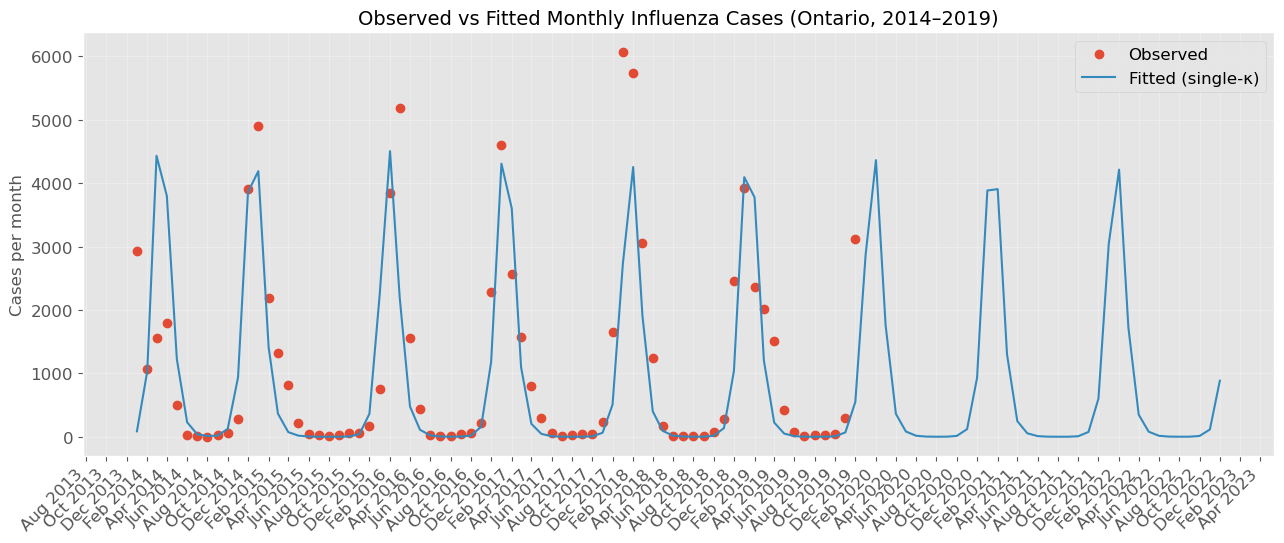


Plot saved to: observed_vs_fitted_ontario_2014_2019_modular.png


In [9]:
# ---------- Main ----------
if __name__ == "__main__":
    # Update this path if needed
    CSV_PATH = r"Influenza cases for all ages, for all sexes, in Ontario.csv"
    if not Path(CSV_PATH).exists():
        raise FileNotFoundError(f"CSV not found at '{CSV_PATH}'. Put the file next to this notebook or update CSV_PATH.")

    # 1) Load data (2014–2019)  (observed window)
    obs = load_monthly_csv(CSV_PATH, year_min=2014, year_max=2019)
    print(f"Loaded {len(obs)} monthly rows from {obs['Date'].min().date()} to {obs['Date'].max().date()}")

    # 2) Hyperparameters for the modular model
    GAMMA = 0.2                    # 1/day (≈5 days infectious period)
    SIGMA_MONTHS = 1.1             # modular smoothing width (months)
    WINTER_WEIGHT = 1.0           # upweight winter months in loss
    MONOTONE_LAMBDA = 200.0        # strength of monotone (W>=F>=S>=U) prior

    # How far past the last observed month to draw the fitted curve (only the fitted line extends)
    FORECAST_MONTHS = 36   # e.g., 3 years of forecasted fit

    # 3) Search + refine (train on observed, then build a forecast tail)
    best = search_and_refine(
        obs, gamma=GAMMA, seed=7,
        sigma_months=SIGMA_MONTHS,
        winter_weight=WINTER_WEIGHT,
        monotone_lambda=MONOTONE_LAMBDA,
        forecast_months=FORECAST_MONTHS   
    )

    # 4) Report (β per season, R0^s, ω, I0, κ, metrics)
    betas = best['betas']; omega = best['omega']; I0 = best['I0']
    which = best['which_kappa']; kappa = best['kappa']; met = best['metrics']
    R0 = {SEASON_NAMES[s]: betas[s]/GAMMA for s in [SPRING, SUMMER, FALL, WINTER]}

    report = {
        "beta (per day)": {SEASON_NAMES[s].lower(): float(betas[s]) for s in [SPRING,SUMMER,FALL,WINTER]},
        "R0 by season": {k.lower(): float(v) for k,v in R0.items()},
        "omega (1/day)": float(omega),
        "immunity_days": float(1.0/omega),
        "I0 (fraction)": float(I0),
        "kappa_type": which,
        "kappa": float(kappa),
        "metrics": met
    }

    # Diagnostics by season (observed months only)
    diag = season_errors_df(best['merged'])
    print("\nSeasonal errors (observed months only):")
    print(json.dumps(diag, indent=2))

    rmse_w = rmse_weighted_df(best['merged'], winter_weight=WINTER_WEIGHT)
    print(f"\nWeighted RMSE (winter_weight={WINTER_WEIGHT}): {rmse_w:.3f}")

    
    print("\n=== Chosen configuration (modular seasons; single-κ) ===")
    print(json.dumps(report, indent=2, default=float))

    # 5) Plot & save 
    out_png = "observed_vs_fitted_ontario_2014_2019_modular.png"
    plot_observed_vs_fitted(best['merged'], which, out_png)
    print(f"\nPlot saved to: {out_png}")